In [2]:
import pandas as pd
import re
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
#stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuqinyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# 读取 Excel 数据
df = pd.read_excel("/Users/wuqinyu/Desktop/NUS课程/sem2/QF5214周一/project/x_data.xlsx")  # 改成你真实的文件名

In [4]:
# ========== 第一步：文本清洗和预处理 ==========
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^\w\s]", "", text)  # 去掉标点
    text = text.lower()  # 全部小写
    return text.strip()

df['clean_tweet'] = df['tweet_text'].apply(clean_text)
df = df[df['clean_tweet'].str.strip().astype(bool)].reset_index(drop=True)

# ========== 第二步：自定义向量器，剔除停用词 ==========
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
custom_stopwords = set([
    'people', 'think', 'today', 'make', 'see', 'like', 'get', 'got', 'just',
    'one', 'know', 'way', 'looks', 'really', 'thing', 'could', 'would',
    'need', 'going', 'let', 'even', 'good', 'great', 'much', 'still', 'well','that','they','are','thats'
])
all_stopwords = list(stop_words.union(custom_stopwords))
#all_stopwords = stop_words.union(custom_stopwords)
#vectorizer_model = CountVectorizer(stop_words=list(all_stopwords), ngram_range=(1, 2))
#vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2))  # 可尝试 ngram=(1,2)

# ========== 第三步：使用更优嵌入模型 ==========
#embedding_model = SentenceTransformer("all-MiniLM-L12-v2")  # 比 L6-v2 稍强，仍保持轻量
embedding_model = SentenceTransformer("all-mpnet-base-v2")

vectorizer_model = CountVectorizer(
    stop_words=all_stopwords,
    ngram_range=(1, 2),
    min_df=2  # 更低的门槛，保留更多关键词
)

# ========== 第四步：BERTopic 配置 ==========
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    language="english",
    calculate_probabilities=True,
    verbose=True,
    min_topic_size=9,         # 控制最小聚类大小，防止全被归为 -1  # 更小的主题聚类
    top_n_words=15             # 每个话题展示更多关键词（默认10）
)

# ========== 第五步：建模并获取话题 ==========
docs = df['clean_tweet'].tolist()
topics, probs = topic_model.fit_transform(docs)
df['topic'] = topics

# ========== 第六步：获取每个话题的关键词 ==========
all_topics = topic_model.get_topics()
topic_words_df = pd.DataFrame({
    "话题编号": list(all_topics.keys()),
    "话题关键词": [[word[0] for word in words] for words in all_topics.values()]
})

# （可选）查看前几行
print(topic_words_df.head())

# ========== 第七步：导出到 Excel 或 CSV ==========
topic_words_df.to_excel("bertopic_关键词输出.xlsx", index=False)
# 或：
# topic_words_df.to_csv("bertopic_关键词输出.csv", index=False)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuqinyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

2025-04-02 21:40:29,980 - BERTopic - Transformed documents to Embeddings
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-04-02 21:40:32,949 - BERTopic - Reduced dimensionality
2025-04-02 21:40:32,969 - BERTopic - Clustered reduced embeddings


   话题编号                                              话题关键词
0    -1  [fiat, regulators, us, big, trump, news, bank,...
1     0  [market, bullish, new, dont, bitcoin, crypto, ...
2     1  [gonna, ghibli, episode, best, discuss, signal...
3     2  [bitcoin, potentially, learn, time, money, abi...
4     3  [party, political, covered, imported, wont, ba...


### 关键词词云可视化

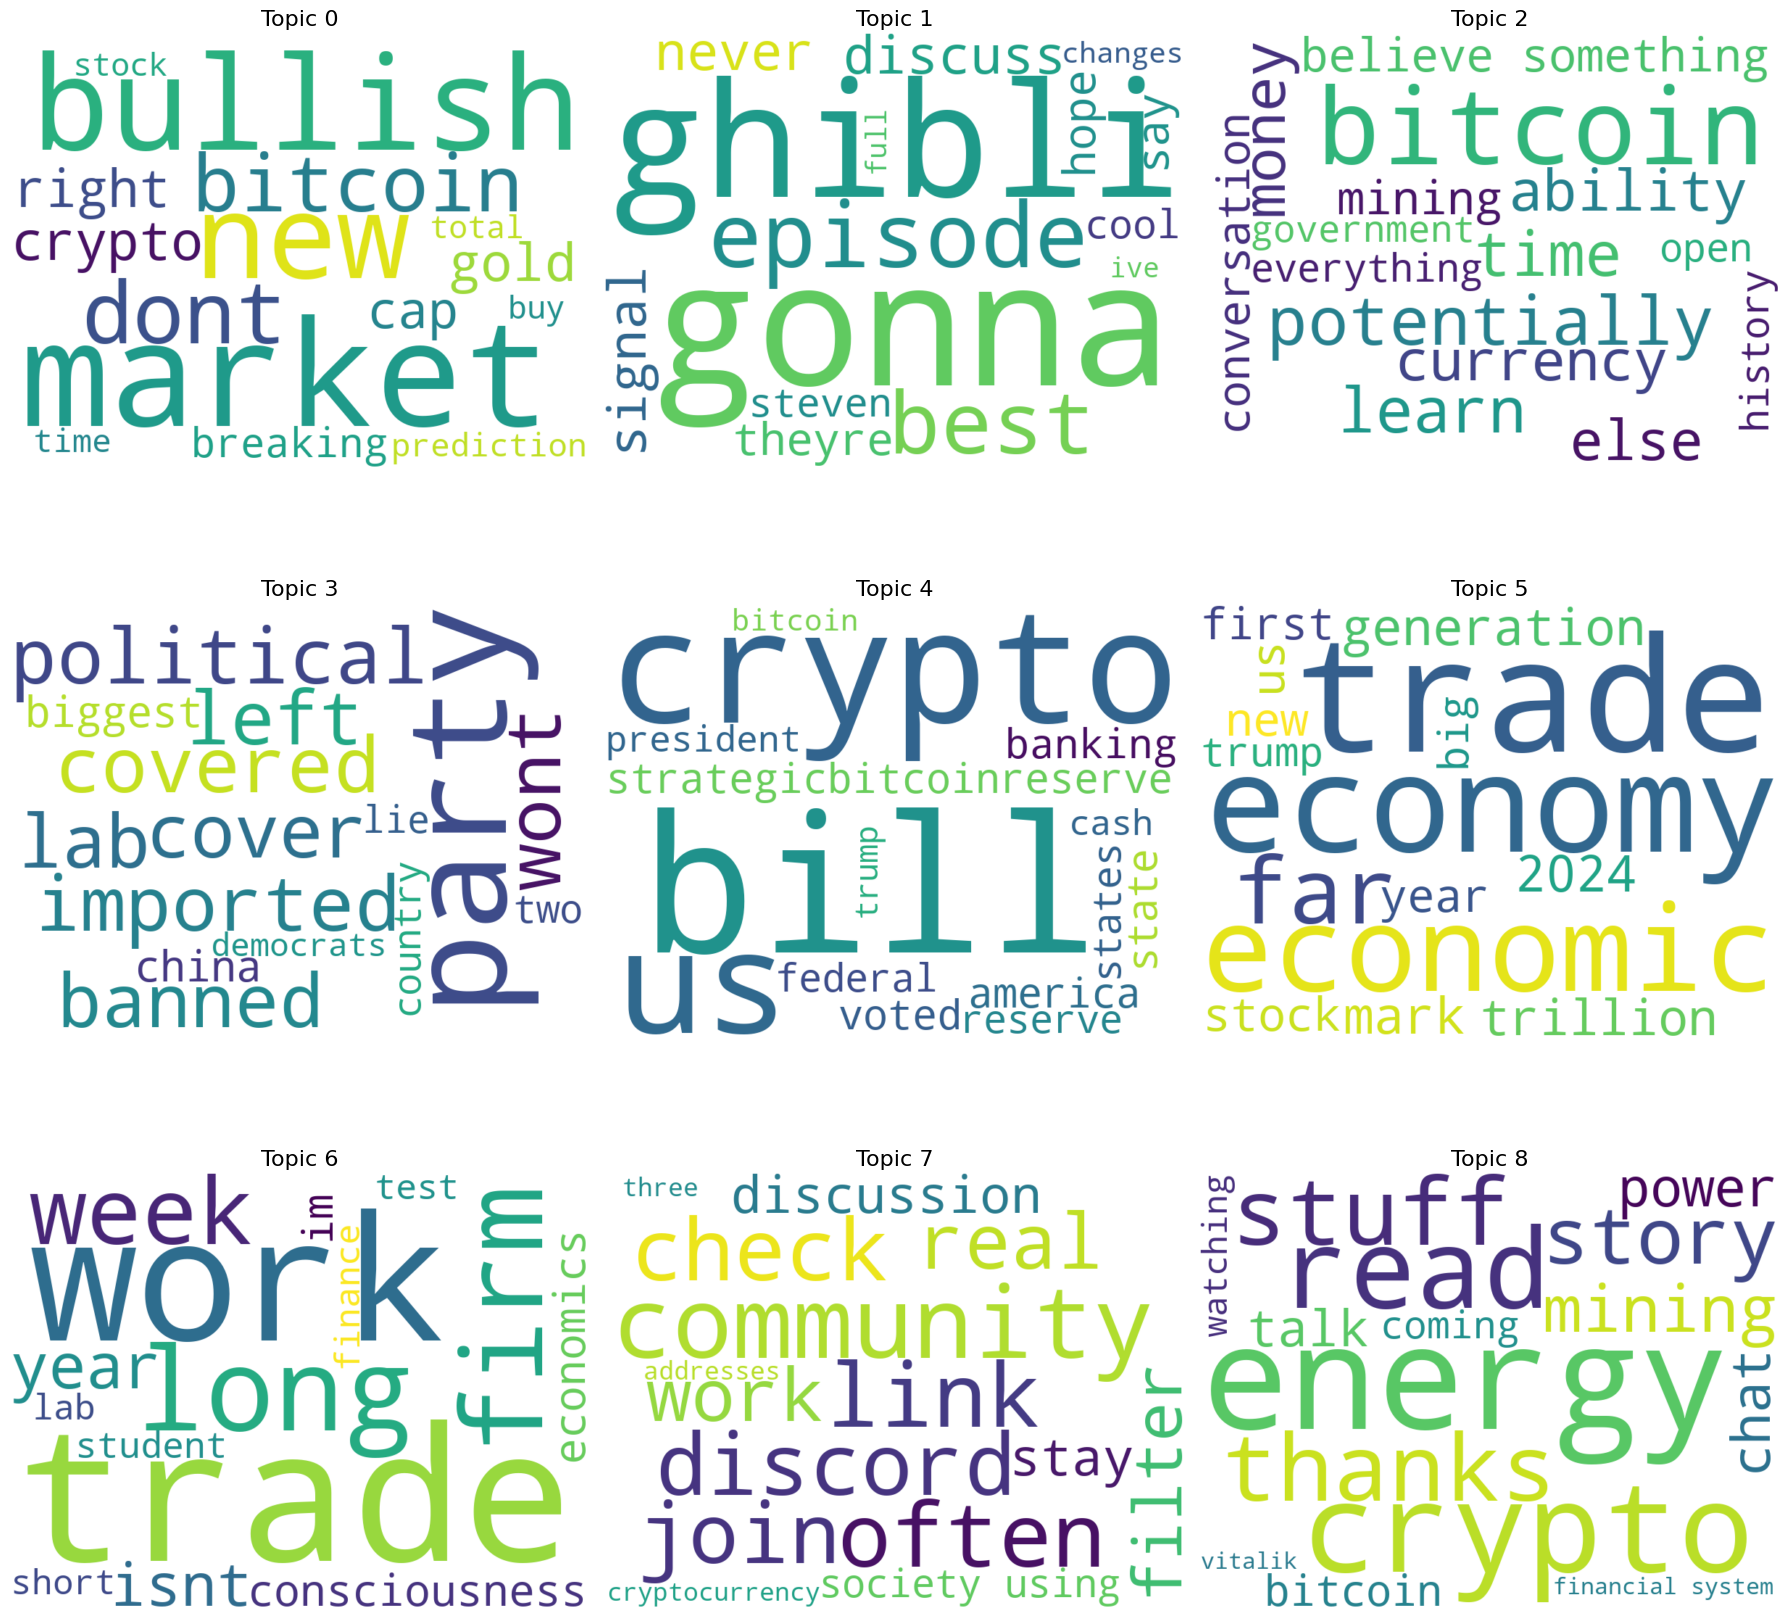

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 过滤掉异常话题(-1)
filtered_topics = {k: v for k, v in all_topics.items() if k != -1}

# 设置画布
n_topics = len(filtered_topics)
n_cols = 3  # 每行3个图
n_rows = int(np.ceil(n_topics / n_cols))

plt.figure(figsize=(18, 6 * n_rows))  # 宽度18英寸，高度动态调整

# 遍历每个话题绘制词云
for i, (topic_num, keywords) in enumerate(filtered_topics.items(), 1):
    # 创建词频字典（使用c-TF-IDF权重）
    word_weights = {word: weight for word, weight in keywords}
    
    # 创建词云对象（权重越高字体越大）
    wordcloud = WordCloud(
        width=800, 
        height=600,
        background_color='white',
        colormap='viridis',  # 使用viridis颜色方案
        prefer_horizontal=0.8,  # 水平词的比例
        min_font_size=10,
        max_words=100
    ).generate_from_frequencies(word_weights)
    
    # 添加子图
    ax = plt.subplot(n_rows, n_cols, i)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Topic {topic_num}', fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [10]:

# ========== 第三步：情感分析器初始化 ==========
sia = SentimentIntensityAnalyzer()

# ========== 第四步：对每个话题聚类下的评论进行分析 ==========
results = []
for topic_id in sorted(df['topic'].unique()):
    sub_df = df[df['topic'] == topic_id]
    tweet_count = len(sub_df)

    # 提取该话题下的所有评论（top_replies）
    all_comments = []
    for block in sub_df['top_replies'].dropna():
        # 分割多条评论，并清洗
        all_comments += [clean_text(c) for c in str(block).split('\n') if len(c.strip()) > 5]

    # 关键词提取（TF-IDF）
    if len(all_comments) > 2:
        tfidf = TfidfVectorizer(stop_words=all_stopwords, max_features=20)
        tfidf_matrix = tfidf.fit_transform(all_comments)
        comment_keywords = tfidf.get_feature_names_out()
        tfidf_array = tfidf_matrix.toarray().sum(axis=0)  # 每个词的总权重
        tfidf_dict = dict(zip(comment_keywords, tfidf_array))  # {词: 权重}
    else:
        comment_keywords = []

    # 情感分析（VADER）
    sentiment_scores = [sia.polarity_scores(c) for c in all_comments]
    pos_comments = [c for c, s in zip(all_comments, sentiment_scores) if s['compound'] >= 0.05]
    neg_comments = [c for c, s in zip(all_comments, sentiment_scores) if s['compound'] <= -0.05]

    pos_ratio = len(pos_comments) / len(all_comments) if all_comments else 0
    neg_ratio = len(neg_comments) / len(all_comments) if all_comments else 0
    sentiment_gap = abs(pos_ratio + neg_ratio)#abs(pos_ratio - neg_ratio)

    # 提取正负向评论关键词
    if pos_comments:
        pos_vec = TfidfVectorizer(stop_words='english', max_features=10)
        pos_vec.fit(pos_comments)
        pos_keywords = pos_vec.get_feature_names_out()
    else:
        pos_keywords = []

    if neg_comments:
        neg_vec = TfidfVectorizer(stop_words='english', max_features=10)
        neg_vec.fit(neg_comments)
        neg_keywords = neg_vec.get_feature_names_out()
    else:
        neg_keywords = []
    #可以加入推文数

    # 用户互动均值
    avg_like = round(sub_df['like_count'].mean(), 2)
    avg_retweet = round(sub_df['retweet_count'].mean(), 2)
    avg_reply = round(sub_df['reply_count'].mean(), 2)

    # 加入话题关键词
    topic_words = topic_model.get_topic(topic_id)
    topic_keywords = [kw for kw, _ in topic_words[:10]] if topic_words else []

    results.append({
        "话题编号": topic_id,
        "话题关键词": topic_keywords,
        "推文总数": tweet_count,
        "评论总数": len(all_comments),
        "评论关键词": list(comment_keywords),
        "评论关键词权重组": tfidf_dict,
        "正向评论关键词": list(pos_keywords),
        "负向评论关键词": list(neg_keywords),
        "正向比例": round(pos_ratio, 2),
        "负向比例": round(neg_ratio, 2),
        "情绪对立差距": round(sentiment_gap, 2),
        "平均点赞": avg_like,
        "平均转发": avg_retweet,
        "平均评论数": avg_reply
    })

# ========== 第五步：输出结果 ==========
summary_df = pd.DataFrame(results)
summary_df.to_excel("web3_topic_analysis_summary.xlsx", index=False)

print("分析完成 ✅，结果已保存至 'web3_topic_analysis_summary.xlsx'")


分析完成 ✅，结果已保存至 'web3_topic_analysis_summary.xlsx'


### 分topic可视化分析

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 假设 summary_df 是你的 DataFrame
summary_df = summary_df[summary_df['话题编号'] != -1]
summary_df = summary_df.reset_index(drop=True)

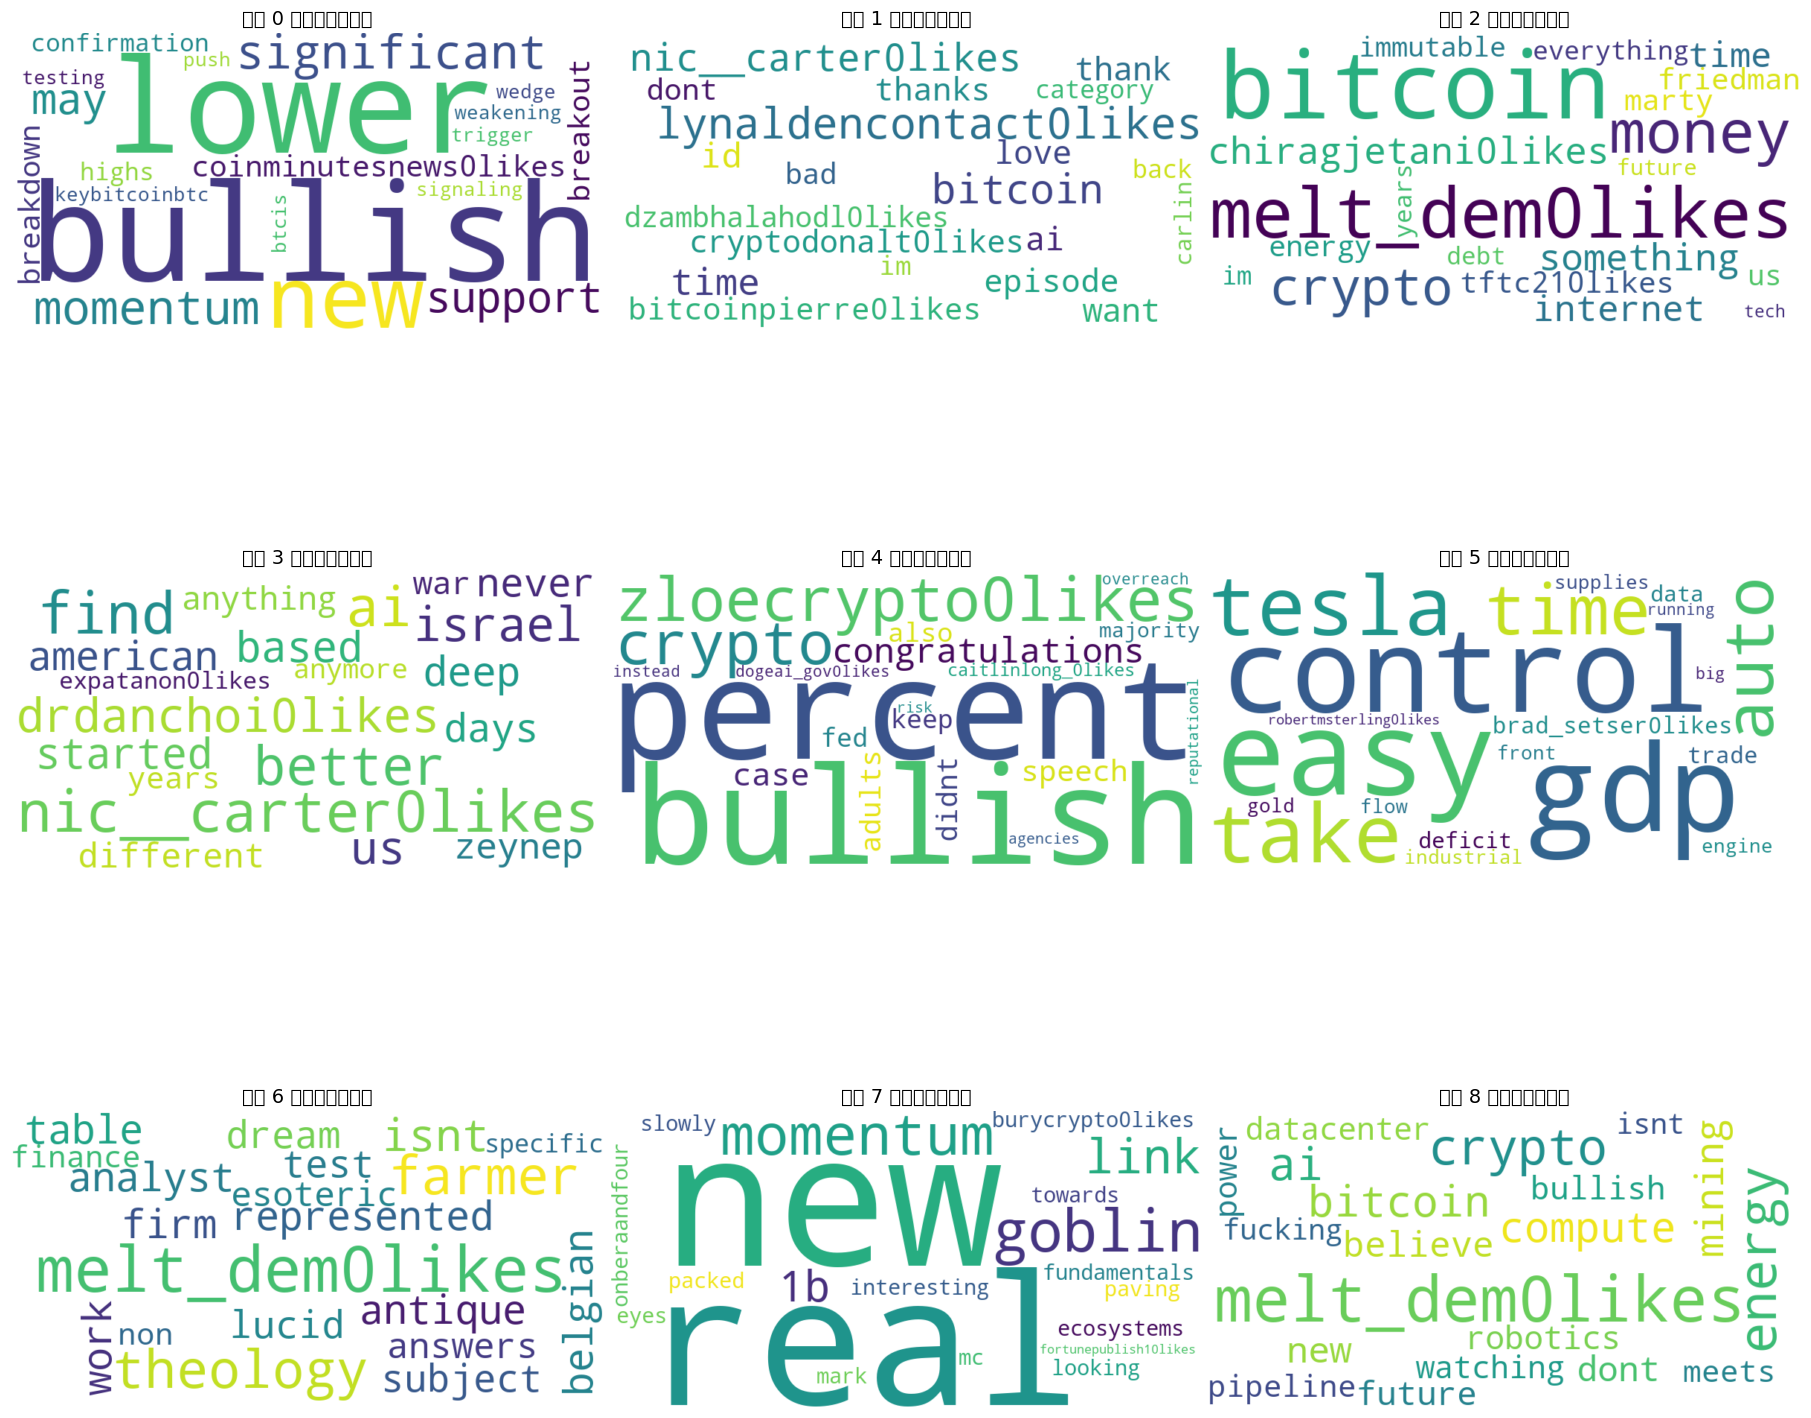

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 每行显示 3 个词云
num_per_row = 3
total = len(summary_df)
rows = (total + num_per_row - 1) // num_per_row  # 向上取整

fig, axes = plt.subplots(rows, num_per_row, figsize=(18, 6 * rows)) #6 * rows

# 扁平化 axes 以便统一索引
axes = axes.flatten()

for i, (idx, row) in enumerate(summary_df.iterrows()):
    topic_id = row['话题编号']
    keyword_weights = row['评论关键词权重组']

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(keyword_weights)

    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"话题 {topic_id} 评论关键词词云", fontsize=14)

# 隐藏多余的 subplot 框架
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0.3) 
#plt.tight_layout()
plt.show()


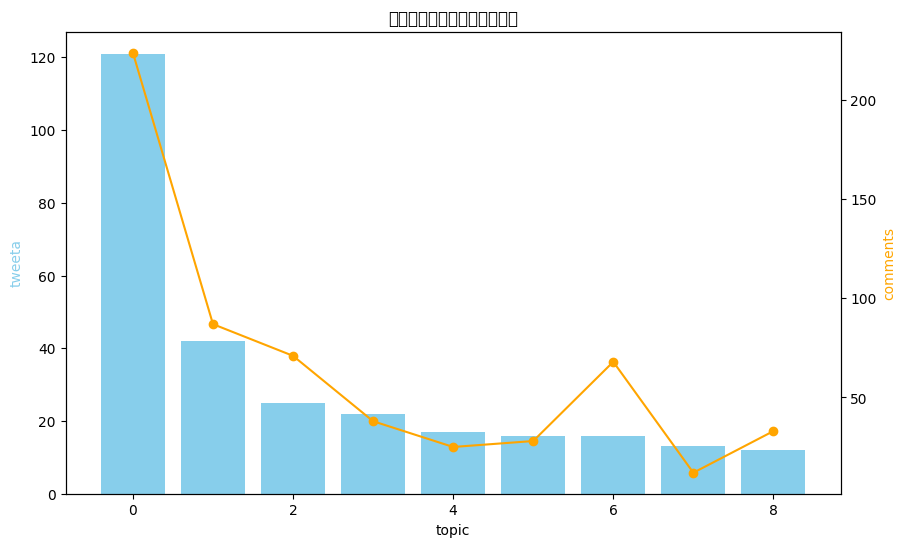

In [13]:

fig, ax1 = plt.subplots(figsize=(10, 6))

x = summary_df['话题编号']
tweets = summary_df['推文总数']
comments = summary_df['评论总数']

ax1.bar(x, tweets, color='skyblue', label='tweets')
ax1.set_ylabel('tweeta', color='skyblue')
ax1.set_xlabel('topic')

ax2 = ax1.twinx()
ax2.plot(x, comments, color='orange', marker='o', label='comments')
ax2.set_ylabel('comments', color='orange')

plt.title('各话题的推文与评论总数对比')
plt.show()


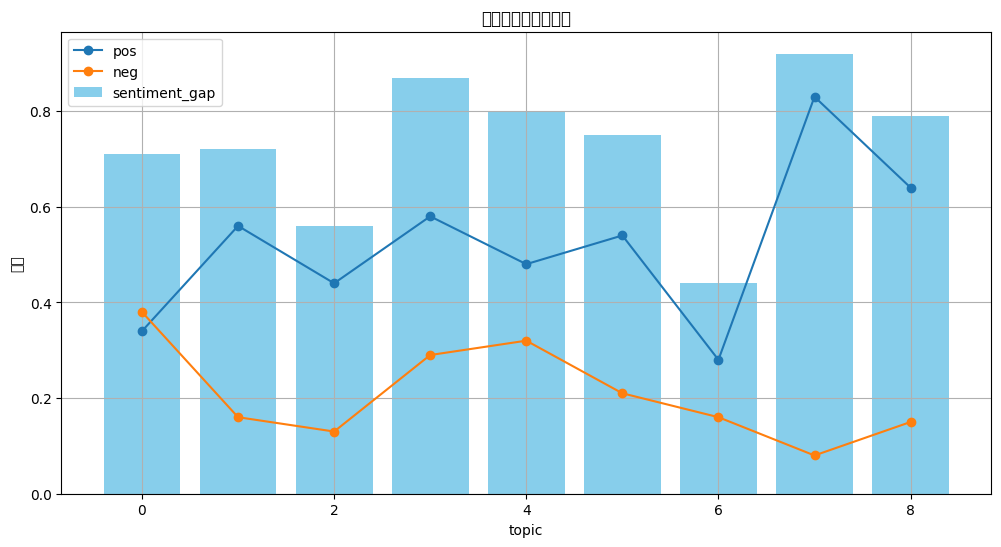

In [14]:
x = summary_df['话题编号']
pos_ratio = summary_df['正向比例']
neg_ratio = summary_df['负向比例']
sentiment_gap = summary_df['情绪对立差距']

plt.figure(figsize=(12, 6))
plt.plot(x, pos_ratio, label='pos', marker='o')
plt.plot(x, neg_ratio, label='neg', marker='o')
#plt.plot(x, sentiment_gap, label='emo_gap', marker='o', linestyle='--')
plt.bar(x, sentiment_gap, color='skyblue', label='sentiment_gap')


plt.xlabel('topic')
plt.ylabel('比例')
plt.title('各话题情绪分布情况')
plt.legend()
plt.grid(True)
plt.show()


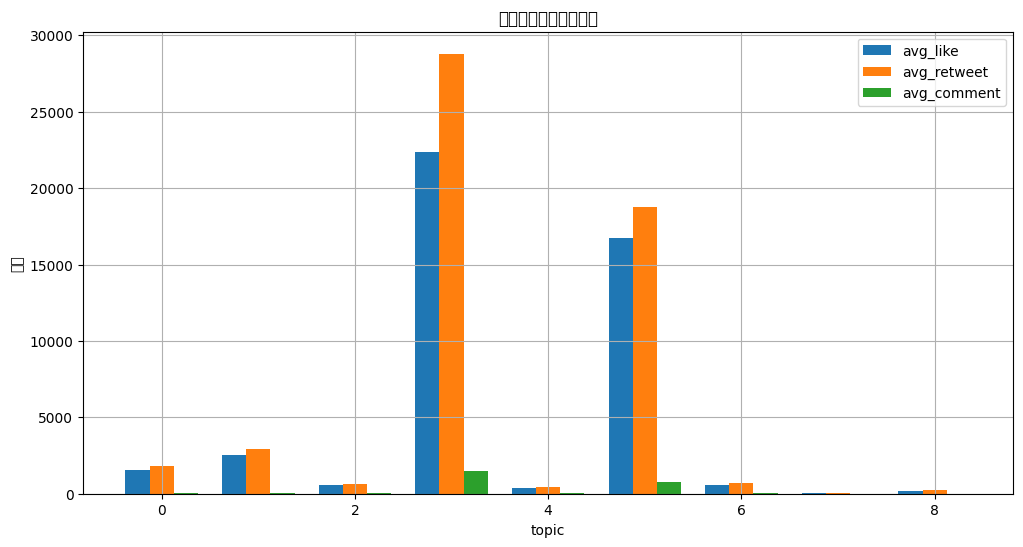

In [15]:
 
x = summary_df['话题编号']
bar_width = 0.25
plt.figure(figsize=(12, 6))

plt.bar(x - bar_width, summary_df['平均点赞'], width=bar_width, label='avg_like')
plt.bar(x, summary_df['平均转发']+summary_df['平均点赞']+summary_df['平均评论数'], width=bar_width, label='avg_retweet')
plt.bar(x + bar_width, summary_df['平均评论数'], width=bar_width, label='avg_comment')

plt.xlabel('topic')
plt.ylabel('均值')
plt.title('各话题的互动均值对比')
plt.legend()
plt.grid(True)
plt.show()


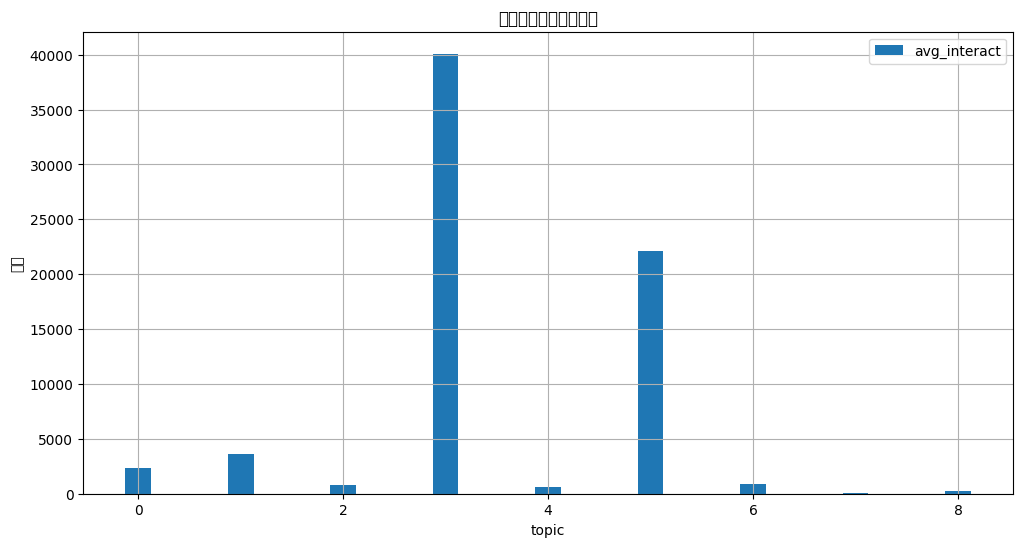

In [16]:

x = summary_df['话题编号']
#bar_width = 0.25
plt.figure(figsize=(12, 6))


plt.bar(x, summary_df['平均点赞']+2*summary_df['平均评论数']+3*summary_df['平均转发'], width=bar_width, label='avg_interact')


plt.xlabel('topic')
plt.ylabel('均值')
plt.title('各话题的互动均值对比')
plt.legend()
plt.grid(True)
plt.show()